# Kuan Chen Chen Milestone 2

## import library

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import json
import requests
import io
import seaborn as sns
import re
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from joblib import dump, load





from matplotlib import pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go


## Dataset manipulate

### Scaler & Label

#### Overall scaler

In [2]:
raw_data = pd.read_csv("all_data.csv")
raw_data.describe(),raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16024 entries, 0 to 16023
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       16024 non-null  object 
 1   overall    16024 non-null  int64  
 2   height_cm  16024 non-null  int64  
 3   weight_kg  16024 non-null  int64  
 4   Age        16024 non-null  int64  
 5   years_pro  2492 non-null   float64
 6   position   16024 non-null  object 
 7   APY        16024 non-null  float64
 8   sport      16024 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 1.1+ MB


(            overall     height_cm     weight_kg           Age    years_pro  \
 count  16024.000000  16024.000000  16024.000000  16024.000000  2492.000000   
 mean      67.438405    183.131990     79.948577     25.463555     4.093900   
 std        8.073197      8.348095     15.214663      4.636865     3.587974   
 min       26.000000    156.000000     49.000000     16.000000     0.000000   
 25%       62.000000    177.000000     71.000000     22.000000     1.000000   
 50%       67.000000    183.000000     76.000000     25.000000     3.000000   
 75%       72.000000    188.000000     83.000000     29.000000     6.000000   
 max       99.000000    226.000000    172.000000     43.000000    22.000000   
 
                 APY  
 count  1.602400e+04  
 mean   1.524409e+06  
 std    4.613287e+06  
 min    0.000000e+00  
 25%    5.200000e+04  
 50%    2.080000e+05  
 75%    1.009068e+06  
 max    6.000000e+07  ,
 None)

In [3]:
raw_data['enter_pro']=raw_data['Age']-raw_data['years_pro']
raw_data['bmi'] =  raw_data['weight_kg']/((raw_data['height_cm']/100)**2)
raw_data

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport,enter_pro,bmi
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL,23.0,30.556813
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL,23.0,26.309431
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL,21.0,26.577895
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL,21.0,25.507601
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL,22.0,28.634039
...,...,...,...,...,...,...,...,...,...,...,...
16019,Chris Paul,88,185,79,34,14.0,PG,41358814.0,NBA,20.0,23.082542
16020,Bradley Beal,88,191,94,26,7.0,SG,28751774.0,NBA,19.0,25.766838
16021,Rudy Gobert,87,216,108,27,6.0,C,27525281.0,NBA,21.0,23.148148
16022,Kyle Lowry,87,183,93,33,13.0,PG,30500000.0,NBA,20.0,27.770313


In [4]:
data_scaled = raw_data.copy()
mm_scaler = MinMaxScaler()
ss_scaler = StandardScaler()

for sport in ["NFL", "NBA","FIFA"]:
    sport_mask = data_scaled["sport"] == sport
    sport_indices = data_scaled[sport_mask].index
    sport_overall = data_scaled.loc[sport_mask, "overall"].values.reshape(-1, 1)
    
    minmax = mm_scaler.fit_transform(sport_overall)
    data_scaled.loc[sport_indices, "overall_minmax"] = minmax.flatten() 
    
    standard = ss_scaler.fit_transform(sport_overall)
    data_scaled.loc[sport_indices, "overall_standard"] = standard.flatten()  


data_scaled

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL,23.0,30.556813,0.835616,1.577731
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL,23.0,26.309431,0.945205,2.372542
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL,21.0,26.577895,0.602740,-0.111244
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL,21.0,25.507601,0.767123,1.080973
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL,22.0,28.634039,0.780822,1.180325
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16019,Chris Paul,88,185,79,34,14.0,PG,41358814.0,NBA,20.0,23.082542,0.677419,1.549576
16020,Bradley Beal,88,191,94,26,7.0,SG,28751774.0,NBA,19.0,25.766838,0.677419,1.549576
16021,Rudy Gobert,87,216,108,27,6.0,C,27525281.0,NBA,21.0,23.148148,0.645161,1.396726
16022,Kyle Lowry,87,183,93,33,13.0,PG,30500000.0,NBA,20.0,27.770313,0.645161,1.396726


#### Data label

In [5]:
for sport in data_scaled["sport"].unique():
    positions = data_scaled[data_scaled["sport"] == sport]["position"].unique()
    print(f"\n{sport} have {len(positions)} positions:")
    print(positions)


NFL have 18 positions:
['QB' 'WR' 'EDGE' 'IDL' 'RT' 'LT' 'CB' 'LG' 'RG' 'LB' 'RB' 'S' 'C' 'TE'
 'K' 'FB' 'P' 'LS']

NBA have 5 positions:
['PF' 'PG' 'SF' 'SG' 'C']

FIFA have 648 positions:
['CB' 'ST' 'GK' 'CM, RB' 'LW, RW, CAM' 'ST, CAM, LW' 'CM' 'ST, CF' 'LB'
 'RB, RM' 'RWB, RB' 'CF, ST, CAM' 'LB, RB, LM' 'CAM, ST' 'LM, RM, CAM'
 'CDM, CM, CB' 'CM, CDM' 'CAM, RM' 'CF, CAM' 'RB, CB' 'CM, CAM, ST'
 'CM, CAM' 'LB, LWB' 'CF, ST' 'ST, LW, RM' 'LM, RM' 'CDM, CM' 'RW, LW, ST'
 'CB, CDM' 'RM, LM' 'RB, RWB, RM' 'RW, CAM' 'ST, CAM' 'CDM' 'RB, CM'
 'CB, LWB' 'CB, RB, LB' 'CAM, CF' 'CAM' 'CM, CDM, CAM' 'CF, RM, CM'
 'LM, LW, CAM' 'LB, CB' 'CAM, LM, RM' 'RB, LB, CB' 'RB, LB' 'CM, LW, ST'
 'ST, LM, CAM' 'CAM, CM' 'CM, CDM, ST' 'CDM, CB, CM' 'LB, RB, CB' 'LM'
 'ST, LM' 'RWB' 'CDM, LB, CM' 'CAM, CM, CDM' 'ST, LW, RW' 'LB, RB'
 'RB, RWB' 'CB, CDM, LB' 'CB, CDM, CM' 'LW, LWB' 'RB, RM, RW'
 'ST, CAM, CM' 'CAM, ST, RW' 'CB, RB' 'CB, RB, RM' 'LM, LW' 'RM, RW, LM'
 'RM, ST, LM' 'CDM, CB' 'CB, RB, CDM' 'L

In [6]:
unique_positions = data_scaled["position"].unique()
position_count = len(unique_positions)
position_count

667

In [7]:
def transform_encoding(data,column, nfl_map, nba_map, new_column_name):
    
    data_simplified = data.copy()
    def apply_position_rule(row):
        if row['sport'] == 'NFL':
            return nfl_map.get(row[column], row[column])
        elif row['sport'] == 'NBA':
            return nba_map.get(row[column], row[column])
        elif row['sport'] == 'FIFA':
            return 0
        else:
            return row['position']  
    
    data_simplified[new_column_name] = data_simplified.apply(apply_position_rule, axis=1)
    return data_simplified


In [8]:
def check_encode(data,label):
    for sport in data['sport'].unique():
        positions = data[data['sport'] == sport][label].unique()
        print(f"\n{sport} have {len(positions)} positions:")
        print(positions)

In [9]:
nfl_18to18_label = {
        'QB': 1,
        'RB': 2,
        'FB': 3 ,
        'WR': 4,
        'TE': 5,
        'LT': 6,
        'RT': 7,
        'LG': 8,
        'RG': 9,
        'C': 10,
        'EDGE': 11,
        'IDL': 12,
        'LB': 13,
        'CB': 14,
        'S': 15,
        'K': 16,
        'P': 17,
        'LS': 18
    }

In [10]:
nba_5to5_lable = {
    'PF': 4, 
    'PG': 1,
    'SF': 3 ,
    'SG': 2,
    'C': 5
}

In [11]:
data_label = transform_encoding(data_scaled,"position", nfl_18to18_label, nba_5to5_lable , "position_label")
data_label 

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard,position_label
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL,23.0,30.556813,0.835616,1.577731,1
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL,23.0,26.309431,0.945205,2.372542,1
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL,21.0,26.577895,0.602740,-0.111244,1
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL,21.0,25.507601,0.767123,1.080973,1
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL,22.0,28.634039,0.780822,1.180325,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16019,Chris Paul,88,185,79,34,14.0,PG,41358814.0,NBA,20.0,23.082542,0.677419,1.549576,1
16020,Bradley Beal,88,191,94,26,7.0,SG,28751774.0,NBA,19.0,25.766838,0.677419,1.549576,2
16021,Rudy Gobert,87,216,108,27,6.0,C,27525281.0,NBA,21.0,23.148148,0.645161,1.396726,5
16022,Kyle Lowry,87,183,93,33,13.0,PG,30500000.0,NBA,20.0,27.770313,0.645161,1.396726,1


In [12]:
check_encode(data_label,"position_label")


NFL have 18 positions:
[ 1  4 11 12  7  6 14  8  9 13  2 15 10  5 16  3 17 18]

NBA have 5 positions:
[4 1 3 2 5]

FIFA have 1 positions:
[0]


#### Position decrease

In [13]:
nfl_18to8_map = {
        'QB': 'QB',
        'RB': 'RB',
        'FB': 'RB',
        'WR': 'Receiver',
        'TE': 'Receiver',
        'LT': 'OL',
        'RT': 'OL',
        'LG': 'OL',
        'RG': 'OL',
        'C': 'OL',
        'EDGE': 'DL',
        'IDL': 'DL',
        'LB': 'LB',
        'CB': 'DB',
        'S': 'DB',
        'K': 'Specialist',
        'P': 'Specialist',
        'LS': 'Specialist'S
    }

In [14]:
nba_5to3_map = {
    'PF':'F', 
    'PG':'G',
    'SF':'F',
    'SG':'G',
    'C':'C'
}

In [15]:
data_encode = transform_encoding(data_label,"position",nfl_18to8_map,nba_5to3_map,"position_simplified")

In [16]:
check_encode(data_encode,'position_simplified' )


NFL have 8 positions:
['QB' 'Receiver' 'DL' 'OL' 'DB' 'LB' 'RB' 'Specialist']

NBA have 3 positions:
['F' 'G' 'C']

FIFA have 1 positions:
[0]


In [17]:
data_encode

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard,position_label,position_simplified
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL,23.0,30.556813,0.835616,1.577731,1,QB
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL,23.0,26.309431,0.945205,2.372542,1,QB
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL,21.0,26.577895,0.602740,-0.111244,1,QB
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL,21.0,25.507601,0.767123,1.080973,1,QB
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL,22.0,28.634039,0.780822,1.180325,1,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16019,Chris Paul,88,185,79,34,14.0,PG,41358814.0,NBA,20.0,23.082542,0.677419,1.549576,1,G
16020,Bradley Beal,88,191,94,26,7.0,SG,28751774.0,NBA,19.0,25.766838,0.677419,1.549576,2,G
16021,Rudy Gobert,87,216,108,27,6.0,C,27525281.0,NBA,21.0,23.148148,0.645161,1.396726,5,C
16022,Kyle Lowry,87,183,93,33,13.0,PG,30500000.0,NBA,20.0,27.770313,0.645161,1.396726,1,G


In [18]:
nfl_8to8_label = {
    'QB': 1,
    'Receiver': 2,
    'DL': 3,
    'OL': 4,
    'DB': 5,
    'LB': 6,
    'RB': 7,
    'Specialist': 8
    }

In [19]:
nba_3to3_label = {
    'F':2, 
    'G':1,
    'C':3
}

In [20]:
df = transform_encoding(data_encode,'position_simplified',nfl_8to8_label,nba_3to3_label,"position_encode_simplified")
check_encode(df,"position_encode_simplified")


NFL have 8 positions:
[1 2 3 4 5 6 7 8]

NBA have 3 positions:
[2 1 3]

FIFA have 1 positions:
[0]


### Data split

In [21]:
df_no_years = df.drop(labels="years_pro",  axis=1)
df_no_years 

,name,overall,height_cm,weight_kg,Age,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard,position_label,position_simplified,position_encode_simplified
0,Dak Prescott,87,188,108,30,QB,60000000.0,NFL,23.0,30.556813,0.835616,1.577731,1,QB,1
1,Joe Burrow,95,193,98,26,QB,55000000.0,NFL,23.0,26.309431,0.945205,2.372542,1,QB,1
2,Jordan Love,70,193,99,24,QB,55000000.0,NFL,21.0,26.577895,0.602740,-0.111244,1,QB,1
3,Trevor Lawrence,82,198,100,23,QB,55000000.0,NFL,21.0,25.507601,0.767123,1.080973,1,QB,1
4,Tua Tagovailoa,83,185,98,25,QB,53100000.0,NFL,22.0,28.634039,0.780822,1.180325,1,QB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16019,Chris Paul,88,185,79,34,PG,41358814.0,NBA,20.0,23.082542,0.677419,1.549576,1,G,1
16020,Bradley Beal,88,191,94,26,SG,28751774.0,NBA,19.0,25.766838,0.677419,1.549576,2,G,1
16021,Rudy Gobert,87,216,108,27,C,27525281.0,NBA,21.0,23.148148,0.645161,1.396726,5,C,3
16022,Kyle Lowry,87,183,93,33,PG,30500000.0,NBA,20.0,27.770313,0.645161,1.396726,1,G,1


In [22]:
df_pro_years = df[df["sport"].isin(["NFL", "NBA"])]
df_pro_years

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard,position_label,position_simplified,position_encode_simplified
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL,23.0,30.556813,0.835616,1.577731,1,QB,1
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL,23.0,26.309431,0.945205,2.372542,1,QB,1
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL,21.0,26.577895,0.602740,-0.111244,1,QB,1
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL,21.0,25.507601,0.767123,1.080973,1,QB,1
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL,22.0,28.634039,0.780822,1.180325,1,QB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16019,Chris Paul,88,185,79,34,14.0,PG,41358814.0,NBA,20.0,23.082542,0.677419,1.549576,1,G,1
16020,Bradley Beal,88,191,94,26,7.0,SG,28751774.0,NBA,19.0,25.766838,0.677419,1.549576,2,G,1
16021,Rudy Gobert,87,216,108,27,6.0,C,27525281.0,NBA,21.0,23.148148,0.645161,1.396726,5,C,3
16022,Kyle Lowry,87,183,93,33,13.0,PG,30500000.0,NBA,20.0,27.770313,0.645161,1.396726,1,G,1


In [23]:
nba_year = df_pro_years[ df_pro_years["sport"] == "NBA"] 
nfl_year = df_pro_years[ df_pro_years["sport"] == "NFL"]
nba = df_no_years [ df_no_years ["sport"] == "NBA"] 
nfl =df_no_years[ df_no_years["sport"] == "NFL"]
fifa = df_no_years [ df_no_years ["sport"] == "FIFA"] 

In [24]:
dataset = [
    (nba_year, "nba_year"),
    (nfl_year, "nfl_year"),
    (nba, "nba"),
    (nfl, "nfl"),
    #(fifa, "fifa")
]

## EDA

In [61]:
 def corr_matrix_plt(df,feature):   
    corr_matrix = df[feature].corr()
    for col in feature:
        total_abs_corr = corr_matrix[col].abs().sum() - 1 
        print(f"{col}: {total_abs_corr:.2f}")
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[feature].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('correlation between feature data')
    plt.show()

### nba

overall: 2.02
height_cm: 1.95
weight_kg: 2.66
position_label: 1.89
Age: 2.25
years_pro: 2.28
bmi: 1.56
enter_pro: 1.19
APY: 2.18


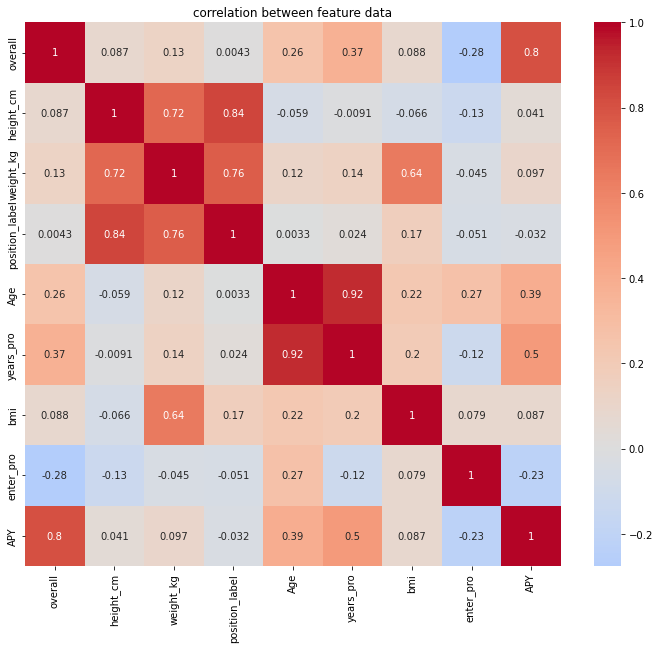

In [68]:
corr_matrix_plt(nba_year,["overall","height_cm", "weight_kg","position_label", "Age", "years_pro","bmi","enter_pro","APY"])

### nfl

overall: 1.71
height_cm: 1.59
weight_kg: 1.99
position_label: 0.57
Age: 1.82
years_pro: 1.82
bmi: 1.67
enter_pro: 1.35
APY: 1.62


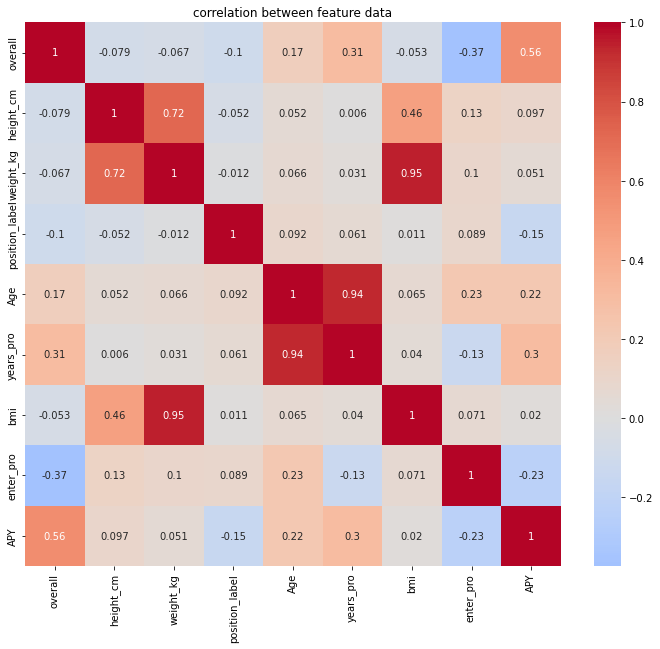

In [67]:
corr_matrix_plt(nfl_year,["overall","height_cm", "weight_kg","position_label", "Age", "years_pro","bmi","enter_pro","APY"])

### fifa

overall: 1.39
height_cm: 1.02
weight_kg: 1.78
Age: 1.13
bmi: 1.10
APY: 0.90


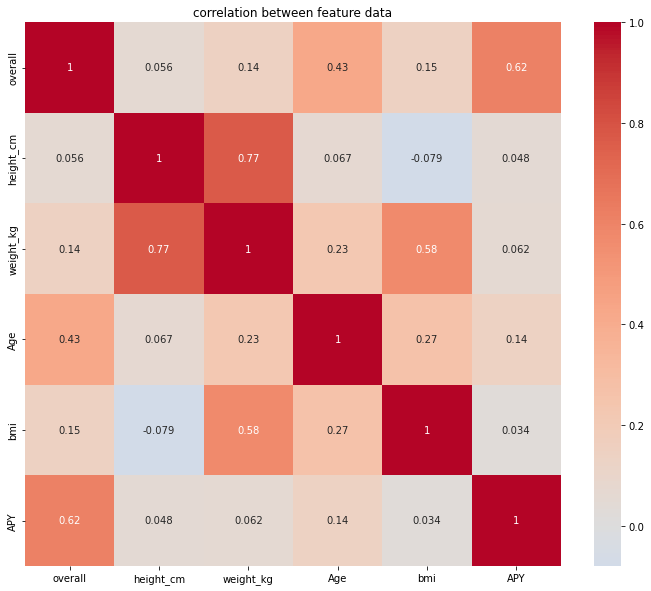

In [66]:
corr_matrix_plt(fifa,["overall","height_cm", "weight_kg", "Age","bmi","APY"])

## Linear regression without position(hypothesis)

In [26]:
def APY_with_overall_linear_regression_model(dataset, overall_type="overall", years=None):
    
    dataset_name = dataset.__name__ if hasattr(dataset, "__name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        x = dataset[[overall_type, "height_cm", "weight_kg", "Age", "years_pro","bmi","enter_pro"]] 
    else:
        x = dataset[[overall_type, "height_cm", "weight_kg", "Age","bmi","enter_pro"]] 
        
    y = dataset["APY"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    lin_model = LinearRegression()
    lin_model.fit(x_train, y_train)
    
    y_pred = lin_model.predict(x_test) 
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results(with overall):")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

In [27]:
def APY_without_overall_linear_regression_model(dataset, years=None):
    
    dataset_name = dataset.__name__ if hasattr(dataset, "__name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        x = dataset[[overall_type, "height_cm", "weight_kg", "Age", "years_pro","bmi","enter_pro"]] 
    else:
        x = dataset[[overall_type, "height_cm", "weight_kg", "Age","bmi","enter_pro"]] 
        
    y = dataset["APY"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    lin_model = LinearRegression()
    lin_model.fit(x_train, y_train)
    
    y_pred = lin_model.predict(x_test) 
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results(without overall):")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

In [28]:
model_try = [APY_with_overall_linear_regression_model, APY_without_overall_linear_regression_model]

## Building model

### Linear models

#### basic

In [29]:
def linear_regression_model(dataset,features, overall_type="overall", years=None):
    dataset_name = dataset.__name__ if hasattr(dataset, "__name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        features_to_use = features.copy()
    else:
        features_to_use = [feat for feat in features if feat not in ["years_pro", "enter_pro"]]
        
    x = dataset[features_to_use]
        
    y = dataset[overall_type]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    lin_model = LinearRegression()
    lin_model.fit(x_train, y_train)
    
    y_pred = lin_model.predict(x_test) 
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

#### ridge

In [30]:
def ridge_model(dataset,features, overall_type="overall", years=None):
    dataset_name = dataset.__name__ if hasattr(dataset, "____name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        features_to_use = features.copy()
    else:
        features_to_use = [feat for feat in features if feat not in ["years_pro", "enter_pro"]]
        
    x = dataset[features_to_use]
        
    y = dataset[overall_type]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }
    ridge = Ridge(random_state=2025)
    
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
 
    y_pred = best_model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results (with tuned hyperparameters):")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

#### lasso

In [31]:
def lasso_model(dataset,features, overall_type="overall", years=None):
    dataset_name = dataset.__name__ if hasattr(dataset, "____name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        features_to_use = features.copy()
    else:
        features_to_use = [feat for feat in features if feat not in ["years_pro", "enter_pro"]]
        
    x = dataset[features_to_use]
        
    y = dataset[overall_type]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'selection': ['cyclic', 'random']
    }
    lasso = Lasso(random_state=2025, max_iter=10000)
    
    grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
 
    y_pred = best_model.predict(x_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results (with tuned hyperparameters):")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

### Nonlinear Models

#### RandomForestRegressor

In [32]:
def randomforest_regression_model(dataset, features,overall_type="overall", years=None):
    dataset_name = dataset.__name__ if hasattr(dataset, "__name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        features_to_use = features.copy()
    else:
        features_to_use = [feat for feat in features if feat not in ["years_pro", "enter_pro"]]
        
    x = dataset[features_to_use]    
    y = dataset[overall_type]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=2025)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2',n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(x_test) 
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results (with tuned hyperparameters):")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

#### GradientBoosting

In [33]:
def GradientBoostingRegressor_model(dataset,features, overall_type="overall", years=None):
    dataset_name = dataset.__name__ if hasattr(dataset, "__name__") else str(dataset)
    has_years_pro = "years_pro" in dataset.columns
    
    if has_years_pro:
        features_to_use = features.copy()
    else:
        features_to_use = [feat for feat in features if feat not in ["years_pro", "enter_pro"]]
        
    x = dataset[features_to_use]
    y = dataset[overall_type]
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    gb_model = GradientBoostingRegressor(random_state=2025)
    grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    

    grid_search.fit(x_train, y_train)
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(x_test) 
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Results (with tuned hyperparameters):")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

## Runing model

In [34]:
def run_model(datasets_with_names, features, models):
    results = []
    if not any(isinstance(feat, list) for feat in features):
        features = [features]  

    for dataset, dataset_name in datasets_with_names:
        for feature_set in features:
            for model_func in models:
                print(f"Running {model_func.__name__} on {dataset_name} with features {feature_set}")
                try:
                    
                    model_result = model_func(dataset, feature_set)
                    results.append({
                        "dataset": dataset_name,
                        "model": model_func.__name__,
                        "features": feature_set,
                        "results": model_result
                    })
                    print("-" * 50)
                except Exception as e:
                    print(f"Error running {model_func.__name__} on {dataset_name} with features {feature_set}: {e}")
    

### checking hypothesis

In [35]:
def run_model_test(datasets_with_names, models):
    results = []

    for dataset, dataset_name in datasets_with_names:

        for model_func in models:
            print(f"Running {model_func.__name__} on {dataset_name}")
            try:
                model_result = model_func(dataset)
                results.append({
                    "dataset": dataset_name,
                    "model": model_func.__name__,
                    "results": model_result
                })
                print("-" * 50)
            except Exception as e:
                print(f"Error running {model_func.__name__} on {dataset_name}: {e}")

In [36]:
run_model_test(dataset, model_try)

Running APY_with_overall_linear_regression_model on nba_year
Model Results(with overall):
MSE: 39275972693900.5547
RMSE: 6267054.5469
R²: 0.6480
--------------------------------------------------
Running APY_without_overall_linear_regression_model on nba_year
Error running APY_without_overall_linear_regression_model on nba_year: name 'overall_type' is not defined
Running APY_with_overall_linear_regression_model on nfl_year
Model Results(with overall):
MSE: 18850055646522.3203
RMSE: 4341665.0777
R²: 0.3746
--------------------------------------------------
Running APY_without_overall_linear_regression_model on nfl_year
Error running APY_without_overall_linear_regression_model on nfl_year: name 'overall_type' is not defined
Running APY_with_overall_linear_regression_model on nba
Model Results(with overall):
MSE: 39190378967868.5312
RMSE: 6260221.9584
R²: 0.6488
--------------------------------------------------
Running APY_without_overall_linear_regression_model on nba
Error running APY_

In [37]:
def run_model_check(datasets_with_names, model_func, **model_kwargs):
    results = []
    for dataset, dataset_name in datasets_with_names:
        print(f"Running {model_func.__name__} on {dataset_name}")

        try:
            model_result = model_func(dataset, **model_kwargs)
            results.append({
                'dataset': dataset_name,
                'model': model_func.__name__,
                'results': model_result
            })
            
            print("-" * 50)
        except Exception as e:
            print(f"Error running {model_func.__name__} on {dataset_name}: {e}")
    

In [38]:
run_model_check(dataset, APY_with_overall_linear_regression_model, overall_type="overall_standard")

Running APY_with_overall_linear_regression_model on nba_year
Model Results(with overall):
MSE: 39190378967868.5781
RMSE: 6260221.9584
R²: 0.6488
--------------------------------------------------
Running APY_with_overall_linear_regression_model on nfl_year
Model Results(with overall):
MSE: 18850055646522.3086
RMSE: 4341665.0777
R²: 0.3746
--------------------------------------------------
Running APY_with_overall_linear_regression_model on nba
Model Results(with overall):
MSE: 39190378967868.5781
RMSE: 6260221.9584
R²: 0.6488
--------------------------------------------------
Running APY_with_overall_linear_regression_model on nfl
Model Results(with overall):
MSE: 18850055646522.3008
RMSE: 4341665.0777
R²: 0.3746
--------------------------------------------------


In [39]:
run_model_check(dataset, APY_with_overall_linear_regression_model, overall_type="overall_minmax")

Running APY_with_overall_linear_regression_model on nba_year
Model Results(with overall):
MSE: 39190378967868.6094
RMSE: 6260221.9584
R²: 0.6488
--------------------------------------------------
Running APY_with_overall_linear_regression_model on nfl_year
Model Results(with overall):
MSE: 18850055646522.3203
RMSE: 4341665.0777
R²: 0.3746
--------------------------------------------------
Running APY_with_overall_linear_regression_model on nba
Model Results(with overall):
MSE: 39190378967868.5781
RMSE: 6260221.9584
R²: 0.6488
--------------------------------------------------
Running APY_with_overall_linear_regression_model on nfl
Model Results(with overall):
MSE: 18850055646522.3125
RMSE: 4341665.0777
R²: 0.3746
--------------------------------------------------


### performance

#### NBA

In [40]:
model=[linear_regression_model,ridge_model,lasso_model,randomforest_regression_model,GradientBoostingRegressor_model]

dataset_nba = [
    (nba_year, "nba_year"),
    (nba, "nba")]


features = [["height_cm", "weight_kg", "Age", "years_pro","bmi","enter_pro"],
            ["height_cm", "weight_kg","position_label", "Age", "years_pro","bmi","enter_pro"],
            ["height_cm", "weight_kg","position_encode_simplified", "Age", "years_pro","bmi","enter_pro"]
           ]

In [41]:
run_model(dataset_nba,features,model)

Running linear_regression_model on nba_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results:
MSE: 29.3617
RMSE: 5.4186
R²: 0.1574
--------------------------------------------------
Running ridge_model on nba_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters: {'alpha': 10.0, 'solver': 'sparse_cg'}
MSE: 28.9839
RMSE: 5.3837
R²: 0.1682
--------------------------------------------------
Running lasso_model on nba_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters: {'alpha': 0.001, 'selection': 'cyclic'}
MSE: 29.3380
RMSE: 5.4165
R²: 0.1581
--------------------------------------------------
Running randomforest_regression_model on nba_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparamet

In [58]:
nba_model = GradientBoostingRegressor(
    learning_rate= 0.01, 
    max_depth= 7, 
    min_samples_leaf=2,
    min_samples_split= 5,
    n_estimators= 200,
    subsample= 0.8,
    random_state=2025 
)


x = nba_year[['height_cm', 'weight_kg', 'position_label', 'Age', 'years_pro', 'bmi', 'enter_pro'] ]
y = nba_year['overall']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)


nba_model.fit(x_train, y_train)
nba_model_data = {
    'model': nba_model,
    'features': ['height_cm', 'weight_kg', 'position_label', 'Age', 'years_pro', 'bmi', 'enter_pro'] 
}
dump(nba_model, 'nba_model.joblib')

['nba_model.joblib']

### FIFA

In [42]:
dataset_fifa = [(fifa, "fifa")]
features_fifa = [["height_cm", "weight_kg", "Age", "years_pro","bmi","enter_pro"]]

In [97]:
run_model(dataset_fifa ,features,model)

Running linear_regression_model on fifa with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results:
MSE: 42.7412
RMSE: 6.5377
R²: 0.1636
--------------------------------------------------
Running ridge_model on fifa with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters: {'alpha': 100.0, 'solver': 'lsqr'}
MSE: 42.7365
RMSE: 6.5373
R²: 0.1637
--------------------------------------------------
Running lasso_model on fifa with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters: {'alpha': 0.01, 'selection': 'cyclic'}
MSE: 42.7357
RMSE: 6.5373
R²: 0.1637
--------------------------------------------------
Running randomforest_regression_model on fifa with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters

In [49]:
fifa



,name,overall,height_cm,weight_kg,Age,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard,position_label,position_simplified,position_encode_simplified
2028,Rúben Miguel Marques dos Santos Fernandes,71,187,81,37,CB,260000.0,FIFA,NaN,23.163373,0.545455,0.644698,0,0,0
2029,Cristiano Ronaldo dos Santos Aveiro,86,187,85,38,ST,3432000.0,FIFA,NaN,24.307244,0.886364,2.715673,0,0,0
2030,Karl Tommy Andreas Johansson,65,184,78,41,CB,44200.0,FIFA,NaN,23.038752,0.409091,-0.183692,0,0,0
2031,José Manuel Reina Páez,77,188,92,40,GK,728000.0,FIFA,NaN,26.029878,0.681818,1.473088,0,0,0
2032,Roque Luis Santa Cruz Cantero,70,191,93,41,ST,26000.0,FIFA,NaN,25.492722,0.522727,0.506633,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15555,Umut Yaşar Keçeci,58,182,73,19,ST,104000.0,FIFA,NaN,22.038401,0.250000,-1.150147,0,0,0
15556,Rakan Al Kaabi,54,174,71,20,"CDM, CM",104000.0,FIFA,NaN,23.450918,0.159091,-1.702407,0,0,0
15557,Rodrigo Frutos,58,188,87,20,GK,26000.0,FIFA,NaN,24.615211,0.250000,-1.150147,0,0,0
15558,Christian Bos,55,180,70,18,RB,26000.0,FIFA,NaN,21.604938,0.181818,-1.564342,0,0,0


In [57]:
fifa_model = GradientBoostingRegressor(
    learning_rate= 0.1, 
    max_depth= 3, 
    min_samples_leaf=1,
    min_samples_split= 2,
    n_estimators= 50,
    subsample= 1.0,
    random_state=2025 
)


x = fifa[["height_cm", "weight_kg", "Age","bmi"] ]
y = fifa['overall']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)


fifa_model.fit(x_train, y_train)
fifa_model_data = {
    'model': fifa_model,
    'features': ["height_cm", "weight_kg", "Age","bmi"]
}
dump(fifa_model, 'fifa_model.joblib')

['fifa_model.joblib']

### NFL

In [95]:

dataset_nfl = [
    (nfl_year, "nfl_year"),
    (nfl, "nba")]


In [94]:
run_model(dataset_nfl,features,model)

Running linear_regression_model on nfl_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results:
MSE: 85.8531
RMSE: 9.2657
R²: 0.1174
--------------------------------------------------
Running ridge_model on nfl_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters: {'alpha': 10.0, 'solver': 'sparse_cg'}
MSE: 85.7542
RMSE: 9.2604
R²: 0.1184
--------------------------------------------------
Running lasso_model on nfl_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparameters):
Best parameters: {'alpha': 0.01, 'selection': 'cyclic'}
MSE: 85.7932
RMSE: 9.2625
R²: 0.1180
--------------------------------------------------
Running randomforest_regression_model on nfl_year with features ['height_cm', 'weight_kg', 'Age', 'years_pro', 'bmi', 'enter_pro']
Model Results (with tuned hyperparamete

In [99]:
nfl_year

,name,overall,height_cm,weight_kg,Age,years_pro,position,APY,sport,enter_pro,bmi,overall_minmax,overall_standard,position_label,position_simplified,position_encode_simplified
0,Dak Prescott,87,188,108,30,7.0,QB,60000000.0,NFL,23.0,30.556813,0.835616,1.577731,1,QB,1
1,Joe Burrow,95,193,98,26,3.0,QB,55000000.0,NFL,23.0,26.309431,0.945205,2.372542,1,QB,1
2,Jordan Love,70,193,99,24,3.0,QB,55000000.0,NFL,21.0,26.577895,0.602740,-0.111244,1,QB,1
3,Trevor Lawrence,82,198,100,23,2.0,QB,55000000.0,NFL,21.0,25.507601,0.767123,1.080973,1,QB,1
4,Tua Tagovailoa,83,185,98,25,3.0,QB,53100000.0,NFL,22.0,28.634039,0.780822,1.180325,1,QB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,K.J. Henry,65,193,116,24,0.0,EDGE,225000.0,NFL,24.0,31.141776,0.534247,-0.608002,11,DL,3
1625,Ochaun Mathis,64,193,112,24,0.0,EDGE,225000.0,NFL,24.0,30.067921,0.520548,-0.707353,11,DL,3
1626,Montrell Washington,68,178,77,24,1.0,WR,225000.0,NFL,23.0,24.302487,0.575342,-0.309947,4,Receiver,2
1627,Danny Gray,70,183,91,24,1.0,WR,225000.0,NFL,23.0,27.173102,0.602740,-0.111244,4,Receiver,2


In [56]:
nfl_model = RandomForestRegressor(
    max_depth=5, 
    min_samples_leaf=4, 
    min_samples_split=10, 
    n_estimators=200,
    random_state=42 
)


x = nfl_year[['height_cm', 'weight_kg', 'position_label', 'Age', 'years_pro', 'bmi', 'enter_pro'] ] 
y = nfl_year['overall']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2025, test_size=0.2)


nfl_model.fit(x_train, y_train)
nfl_model_data = {
    'model': nfl_model,
    'features': ['height_cm', 'weight_kg', 'position_label', 'Age', 'years_pro', 'bmi', 'enter_pro']
}
dump(nfl_model_data, 'nfl_model.joblib')

['nfl_model.joblib']